# Project - Second Requirement

### Include packages.

In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy.stats import norm
from itertools import product
from scipy.optimize import linprog
from collections import Counter

### The first thing to do is to code the environment.

In [2]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [3]:
class PricingEnvironmentMultiProduct(Environment):
    def __init__(self, costs, mean_valuations, std_valuations, buyers_per_round):
        self.N = len(costs)
        self.costs = np.array(costs)
        self.mean_valuations = np.array(mean_valuations)
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round

    def round(self, prices):
        sales_per_product = np.zeros(self.N)
        rewards_per_product = np.zeros(self.N)

        for i in range(self.N):
            p_t = prices[i]
            prob_buy = 1 - norm.cdf(p_t, loc=self.mean_valuations[i], scale=self.std_valuations[i])
            num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)
            reward_i = (p_t - self.costs[i]) * num_sales

            sales_per_product[i] = num_sales
            rewards_per_product[i] = reward_i

        total_reward = np.sum(rewards_per_product)
        return sales_per_product, total_reward, rewards_per_product

### Now define the setting...

We assume there is a product "true value", at which around 50% people would buy. We call it so, because in gaussian hypothesis, it represents the peak value "most customers agree" on.

In [4]:
# --- Global Settings ---

N = 4                       # Number of products
T = 20000                   # Time horizon (number of rounds)
n_trials = 3                # Number of independent trials for averaging

# --- Pricing Grid and Product Info ---

price_step = 0.5

K = 4         # Number of price options (arms per product)

costs = np.array([2.00, 1.50, 0.50, 4.00])
values = np.array([3.00, 2.50, 1.50, 6.00])
std_valuations = np.array([1.0, 0.8, 0.5, 1.5])

assert len(costs) == len(values) == len(std_valuations) == N, "costs, values, std_valuations must all be of length N"
assert np.all(costs < values), "Each product's cost must be less than its corresponding value"

# --- Build per-product price grids ---
price_grids = []
for i in range(N):
    p_min = 0.5 * costs[i]
    p_max = values[i] * 1.5
    custom_prices = np.linspace(p_min, p_max, 4)
    price_grids.append(custom_prices)

# --- Market and Inventory Parameters ---

B = 120000 * N                          # Total inventory (shared among all products)
rho = B/T                               # Budget per round

# --- Derived Buyer Generation per Round ---

buyers_per_round = 50                   # Number of buyers per round per product
assert buyers_per_round >= 1, "Must have at least one buyer per round"

# --- Other Parameters ---

s = 30                  # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

### Expected demand and profit using theoretical expectations.

In [5]:
# --- Initialize matrices for expected demand/profit ---
expected_demand_matrix = []
expected_profit_matrix = []

for i in range(N):
    prices = price_grids[i]
    demands = []
    profits = []
    for p in prices:
        prob_buy = 1 - norm.cdf(p, loc=values[i], scale=std_valuations[i])
        expected_demand = buyers_per_round * prob_buy
        expected_profit = (p - costs[i]) * expected_demand
        demands.append(expected_demand)
        profits.append(expected_profit)
    expected_demand_matrix.append(demands)
    expected_profit_matrix.append(profits)

expected_demand_matrix = np.array(expected_demand_matrix)
expected_profit_matrix = np.array(expected_profit_matrix)

# --- Find best price per product ---
best_price_indices = np.argmax(expected_profit_matrix, axis=1)
best_super_arm = tuple(best_price_indices.tolist())
best_prices = np.array([price_grids[i][idx] for i, idx in enumerate(best_price_indices)])
best_profits = expected_profit_matrix[np.arange(N), best_price_indices]

# --- Summary ---
print("=== Best Expected Prices ===")
for i in range(N):
    print(f"Product {i}: optimal price = €{best_prices[i]:.2f}, expected profit = €{best_profits[i]:.2f}")
print()

print(f"Best super arm: {tuple(idx+1 for idx in best_super_arm)} with expected profit = €{np.sum(best_profits):.2f}")
print(f"Expected total demand: {np.sum(expected_demand_matrix[np.arange(N), best_price_indices]):.2f} units")

=== Best Expected Prices ===
Product 0: optimal price = €3.33, expected profit = €24.63
Product 1: optimal price = €2.75, expected profit = €23.58
Product 2: optimal price = €1.58, expected profit = €23.50
Product 3: optimal price = €6.67, expected profit = €43.78

Best super arm: (3, 3, 3, 3) with expected profit = €115.49
Expected total demand: 75.45 units


### Let us visualize our setting.

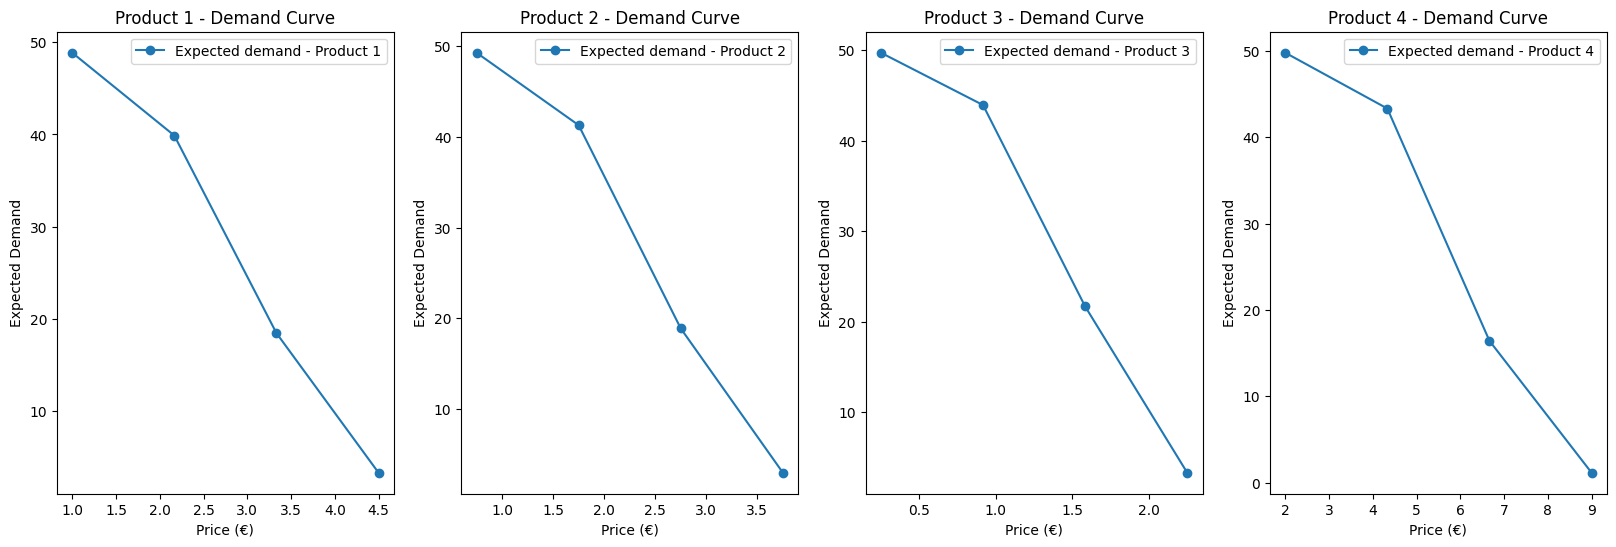

In [6]:
# --- Visualization ---

fig1, axs1 = plt.subplots(1, 4, figsize=(20, 6))

# Plot items
for i in range(min(N, 4)):
    axs1[i].plot(price_grids[i], expected_demand_matrix[i], label=f'Expected demand - Product {i+1}', marker='o')
    axs1[i].set_title(f"Product {i+1} - Demand Curve")
    axs1[i].set_xlabel("Price (€)")
    axs1[i].set_ylabel("Expected Demand")
    axs1[i].legend()

### Agent

In [7]:
# If rewards lie in [0, R], you must scale the confidence term by self.range = R maximum possible reward in a round t.
R_ucb = np.array( [ buyers_per_round * (np.max(price_grids[i]) - costs[i]) for i in range(N) ] )
R_lcb = np.array( [ buyers_per_round * (np.max(price_grids[i]) - costs[i]) for i in range(N) ] ) / N

class CombinatorialUCB:
    def __init__(self, N, K, B, T, price_grids, R_ucb, R_lcb):
        self.N = N                      # Number of products
        self.K = K                      # Number of prices per product
        self.B = B                      # Total budget (inventory)
        self.T = T                      # Horizon
        self.R_ucb = R_ucb              # For reward UCB
        self.R_lcb = R_lcb              # For sales LCB
        self.price_grids = price_grids
        self.rho = rho                  # Budget per round
        self.t = 0
        self.inventory = B

        # All possible super-arms = combinations of K indices across N products
        self.super_arms = list(product(range(K), repeat=N))
        self.A = len(self.super_arms)

        # Per-arm statistics (N products × K prices)
        self.N_pulls = np.zeros((N, K))                 # Number of times (i,k) pulled
        self.avg_rewards = np.zeros((N, K))             # Average reward per (i,k)
        self.avg_sales = np.zeros((self.N, self.K))     # Average sales per (i,k)
        self.last_superarm = None                       # Store last super-arm for update

    def pull_arm(self):
        if self.inventory < 1:
            self.last_superarm = None
            return None

        # Compute UCB and LCB for all (i, k)
        ucb = np.zeros((self.N, self.K))
        lcb_sales = np.zeros((self.N, self.K))
        for i in range(self.N):
            for k in range(self.K):
                if self.N_pulls[i, k] == 0:
                    # Force exploration: pick this (i, k) with random others
                    arm = [np.random.choice(range(self.K)) for _ in range(self.N)]
                    arm[i] = k
                    self.last_superarm = tuple(arm)
                    return self.last_superarm
                # Compute UCB and LCB bounds
                bound_ucb = self.R_ucb[i] * np.sqrt(2 * np.log(self.T) / self.N_pulls[i, k])
                bound_lcb = self.R_lcb[i] * np.sqrt(2 * np.log(self.T) / self.N_pulls[i, k])
                ucb[i, k] = self.avg_rewards[i, k] + bound_ucb
                lcb_sales[i, k] = max(0, self.avg_sales[i, k] - bound_lcb)

        # For each super-arm, sum UCB rewards and LCB sales
        ucb_superarm_rewards = []
        lcb_superarm_sales = []
        for a in self.super_arms:
            reward = sum(ucb[i, a[i]] for i in range(self.N))
            consumption = sum(lcb_sales[i, a[i]] for i in range(self.N))
            ucb_superarm_rewards.append(reward)
            lcb_superarm_sales.append(consumption)

        # Solve LP: max γ ⋅ ucb_rewards s.t. γ ⋅ lcb_sales ≤ ρ, sum γ = 1, γ ≥ 0
        action_idx = self.solve_lp(np.array(ucb_superarm_rewards), np.array(lcb_superarm_sales))
        self.last_superarm = self.super_arms[action_idx]

        return self.last_superarm

    def solve_lp(self, ucb_rewards, lcb_sales):
        c = -ucb_rewards
        A_ub = [lcb_sales]
        b_ub = [self.rho]
        A_eq = [np.ones(self.A)]
        b_eq = [1]
        bounds = [(0, 1)] * self.A

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        if res.success:
            gamma = res.x
            return np.random.choice(self.A, p=gamma)
        else:
            feasible_indices = [i for i, cost in enumerate(lcb_sales) if cost <= self.rho]
            if feasible_indices:
                # Among feasible, pick one with max UCB reward
                best_idx = max(feasible_indices, key=lambda i: ucb_rewards[i])
                return best_idx
            else:
                # No feasible arm even under fallback — return one with *least* consumption
                min_cost_idx = int(np.argmin(lcb_sales))
                return min_cost_idx

    def update(self, sales, individual_rewards):
        for i in range(self.N):
            k = self.last_superarm[i]
            self.N_pulls[i, k] += 1
            self.avg_rewards[i, k] += (individual_rewards[i] - self.avg_rewards[i, k]) / self.N_pulls[i, k]
            self.avg_sales[i, k] += (sales[i] - self.avg_sales[i, k]) / self.N_pulls[i, k]

        self.inventory -= np.sum(sales)
        self.t += 1

### Run

Write per-round budget-aware mixed-strategy clairvoyant.

In [8]:
# --- Clairvoyant mixed strategy for multi-product case ---

super_arms = list(product(range(K), repeat=N))
A = len(super_arms)
expected_rewards = []
expected_consumptions = []

# Compute expected reward and consumption for each super-arm
for a in super_arms:
    prices = [price_grids[i][a[i]] for i in range(N)]
    expected_sales = [buyers_per_round * norm.cdf((values[i] - prices[i]) / std_valuations[i]) for i in range(N)]
    reward = sum((prices[i] - costs[i]) * expected_sales[i] for i in range(N))
    consumption = sum(expected_sales)
    expected_rewards.append(reward)
    expected_consumptions.append(consumption)

# Solve LP: maximize expected reward under average budget constraint
c = -np.array(expected_rewards)  # maximize → minimize negative
A_ub = [expected_consumptions]
b_ub = [rho]
A_eq = [np.ones(A)]
b_eq = [1]
bounds = [(0, 1)] * A

res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
gamma_star = res.x
clairvoyant_mixed_reward_per_round = np.dot(gamma_star, expected_rewards)
clairvoyant_mixed_total_reward = clairvoyant_mixed_reward_per_round * T
clairvoyant_rewards_mixed = np.full(T, clairvoyant_mixed_reward_per_round)

print("--- Mixed Strategy Clairvoyant ---")
print(f"Expected reward per round: {clairvoyant_mixed_reward_per_round:.2f}")
print(f"Expected total reward: {clairvoyant_mixed_total_reward:.2f}")

print("\nMixed strategy gamma:")
for i, prob in enumerate(gamma_star):
    if prob > 1e-4:
        print(f"  super-arm {tuple(idx+1 for idx in super_arms[i])}: weight = {prob:.3f}, expected cost = {expected_consumptions[i]:.2f}")

--- Mixed Strategy Clairvoyant ---
Expected reward per round: 59.51
Expected total reward: 1190138.76

Mixed strategy gamma:
  super-arm (4, 4, 4, 3): weight = 0.866, expected cost = 26.05
  super-arm (4, 4, 4, 4): weight = 0.134, expected cost = 10.77


We waste so many products in the exploration phase!

In [9]:
regret_per_trial = []
regret_per_trial_mixed = []
expected_clairvoyant_rewards_per_round = np.sum(best_profits)
expected_clairvoyant_rewards_per_round_mixed = clairvoyant_mixed_reward_per_round

# Run n-trials
for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironmentMultiProduct(costs=costs, mean_valuations=values, std_valuations=std_valuations, buyers_per_round=buyers_per_round)

    agent = CombinatorialUCB(N, K, B, T, price_grids, R_ucb=R_ucb, R_lcb=R_lcb)
    regret_over_time_this_trial = []
    regret_over_time_this_trial_mixed = []
    sales_per_round = []

    # Time horizon loop
    rewards_this_trial = []
    for t in range(T):
        a_t = agent.pull_arm()

        if a_t is None:
            # If agent stops early, fill remaining rounds with 0 reward
            rewards_this_trial.extend([0] * (T - t))
            break

        prices = [price_grids[i][a_t[i]] for i in range(N)]
        sales, total_reward, rewards_per_product = env.round(prices)
        agent.update(sales, rewards_per_product)

        if seed == n_trials - 1:
            sales_per_round.append(np.sum(sales))  # Track total sales this round

        rewards_this_trial.append(total_reward)

    # Compute regret arrays for this trial
    regret_per_trial.append(np.cumsum(expected_clairvoyant_rewards_per_round - np.array(rewards_this_trial)))
    regret_per_trial_mixed.append(np.cumsum(expected_clairvoyant_rewards_per_round_mixed - np.array(rewards_this_trial)))

# Compute average (and standard deviation) of regret across all trials
average_regret = np.array(regret_per_trial).mean(axis=0)
average_regret_mixed = np.array(regret_per_trial_mixed).mean(axis=0) 
regret_sd = np.array(regret_per_trial).std(axis=0)
regret_sd_mixed = np.array(regret_per_trial_mixed).std(axis=0)

### Show regret

Final Total Regret against standard approach: 1411368.9522446992
Final Total Regret against Budget-Aware Mixed-Strategy: 291660.51051109115


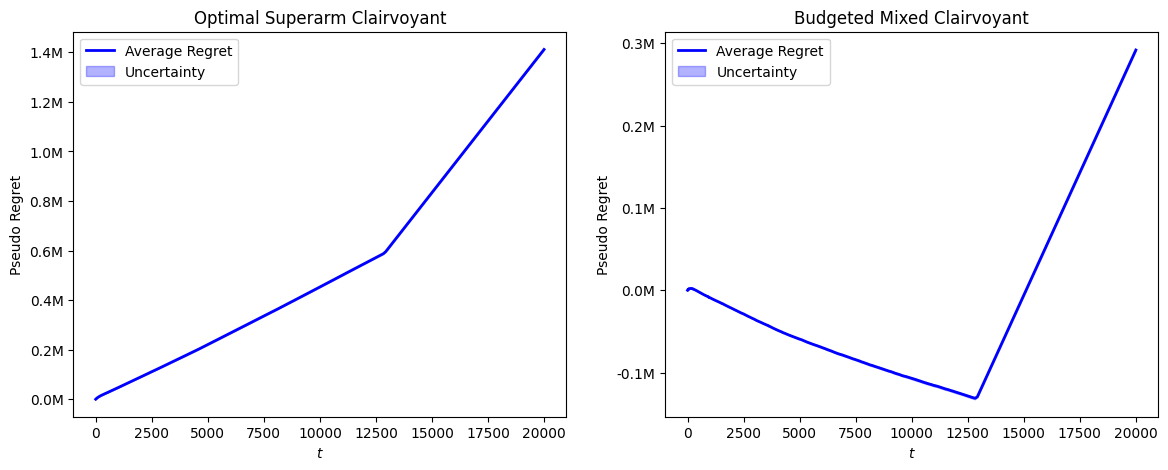

In [10]:
# --- Plotting Average Cumulative Regret (Pseudo Regret) ---
print("Final Total Regret against standard approach:", average_regret[-1])
print("Final Total Regret against Budget-Aware Mixed-Strategy:", average_regret_mixed[-1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

ax1.plot(np.arange(0, T), average_regret, 'b-', linewidth=2, label='Average Regret')
ax1.fill_between(np.arange(0, T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, color='blue', label='Uncertainty')
ax1.set_title('Optimal Superarm Clairvoyant')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Pseudo Regret')
ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

ax2.plot(np.arange(0, T), average_regret_mixed, 'b-', linewidth=2, label='Average Regret')
ax2.fill_between(np.arange(0, T), average_regret_mixed - regret_sd / np.sqrt(n_trials), average_regret_mixed + regret_sd_mixed / np.sqrt(n_trials), alpha=0.3, color='blue', label='Uncertainty')
ax2.set_title('Budgeted Mixed Clairvoyant')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Pseudo Regret')
ax2.legend()
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax2.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

### Budget Constraint Behaviour

Visualize.

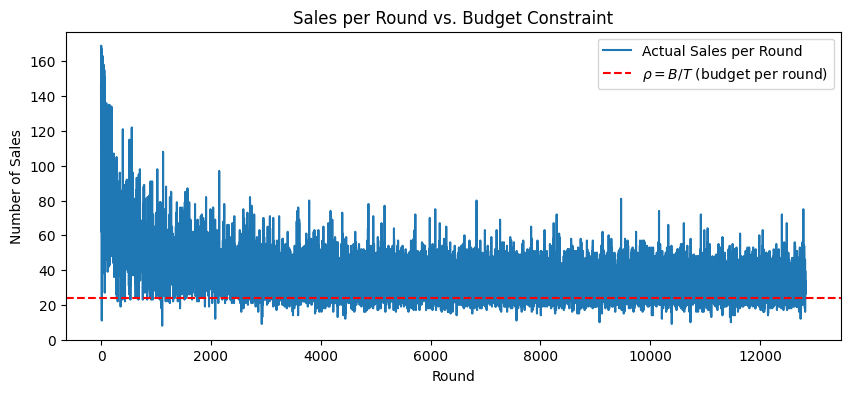

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(sales_per_round, label='Actual Sales per Round')
plt.axhline(y=B/T, color='red', linestyle='--', label=r'$\rho = B/T$ (budget per round)')
plt.xlabel('Round')
plt.ylabel('Number of Sales')
plt.title('Sales per Round vs. Budget Constraint')
_ = plt.legend()

What happens if we reduce the value of R_lcb?

In [12]:
sales_results_by_z = {}

for z in [1, N, 100]:

    # Recompute R_lcb for current z
    R_lcb = np.array([buyers_per_round * (np.max(price_grids[i]) - costs[i]) for i in range(N)]) / N / z

    sales_per_round = []  # Track sales only in the final trial

    for seed in range(n_trials):
        np.random.seed(seed)
        env = PricingEnvironmentMultiProduct(costs=costs, mean_valuations=values, std_valuations=std_valuations, buyers_per_round=buyers_per_round)
        agent = CombinatorialUCB(N, K, B, T, price_grids, R_ucb=R_ucb, R_lcb=R_lcb)

        for t in range(T):
            a_t = agent.pull_arm()
            if a_t is None:
                if seed == n_trials - 1:
                    sales_per_round.extend([0] * (T - t))
                break

            prices = [price_grids[i][a_t[i]] for i in range(N)]
            sales, total_reward, rewards_per_product = env.round(prices)
            agent.update(sales, rewards_per_product)

            if seed == n_trials - 1:
                sales_per_round.append(np.sum(sales))  # Total sales for this round

        # Ensure sales array is length T
        if seed == n_trials - 1:
            while len(sales_per_round) < T:
                sales_per_round.append(0)

    # Store results for this z
    sales_results_by_z[z] = sales_per_round
    # Choose a "best" z for further analysis/plots if needed
    best_z = N

Plot.

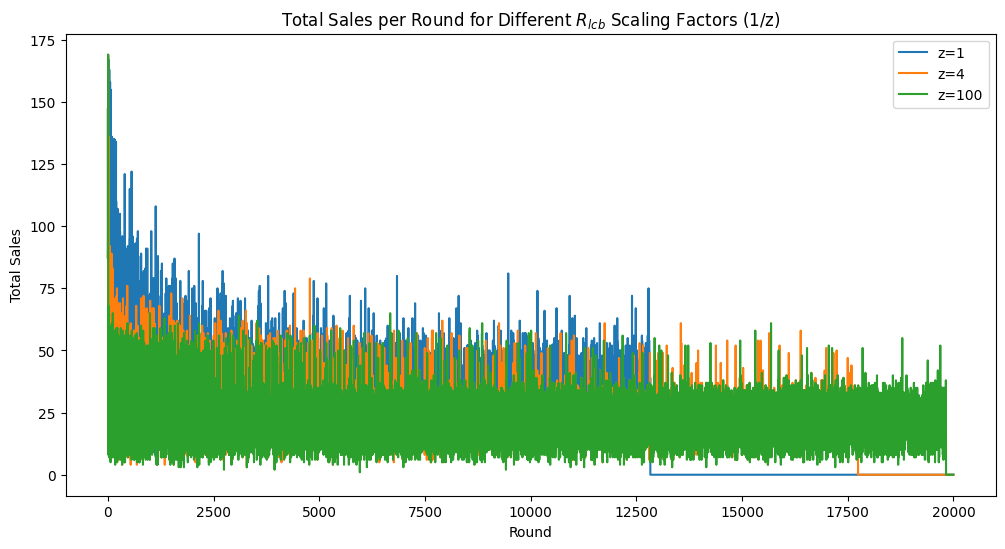

In [13]:
plt.figure(figsize=(12, 6))
for z, sales in sales_results_by_z.items():
    plt.plot(sales, label=f'z={z}')
plt.xlabel("Round")
plt.ylabel("Total Sales")
plt.title("Total Sales per Round for Different $R_{lcb}$ Scaling Factors (1/z)")
_ = plt.legend()

### Explore more at initialization

Instead of forcing every arm, let's try by forcing every superarm.

In [14]:
R_lcb = np.array([buyers_per_round * (np.max(price_grids[i]) - costs[i]) for i in range(N)]) / N / best_z

class CombinatorialUCB:
    def __init__(self, N, K, B, T, price_grids, R_ucb, R_lcb):
        self.N = N                      # Number of products
        self.K = K                      # Number of prices per product
        self.B = B                      # Total budget (inventory)
        self.T = T                      # Horizon
        self.R_ucb = R_ucb              # For reward UCB
        self.R_lcb = R_lcb              # For sales LCB
        self.price_grids = price_grids
        self.rho = rho                  # Budget per round
        self.t = 0
        self.inventory = B

        # All possible super-arms = combinations of K indices across N products
        self.super_arms = list(product(range(K), repeat=N))
        self.untried_superarms = set(self.super_arms)  # Track unexplored superarms
        self.A = len(self.super_arms)

        # Per-arm statistics (N products × K prices)
        self.N_pulls = np.zeros((N, K))                 # Number of times (i,k) pulled
        self.avg_rewards = np.zeros((N, K))             # Average reward per (i,k)
        self.avg_sales = np.zeros((self.N, self.K))     # Average sales per (i,k)
        self.last_superarm = None                       # Store last super-arm for update

    def pull_arm(self):
        if self.inventory < 1:
            self.last_superarm = None
            return None
        
        if self.untried_superarms:
            arm = self.untried_superarms.pop()
            self.last_superarm = arm
            return arm

        # Compute UCB and LCB for all (i, k)
        ucb = np.zeros((self.N, self.K))
        lcb_sales = np.zeros((self.N, self.K))
        for i in range(self.N):
            for k in range(self.K):
                # Compute UCB and LCB bounds
                bound_ucb = self.R_ucb[i] * np.sqrt(2 * np.log(self.T) / self.N_pulls[i, k])
                bound_lcb = self.R_lcb[i] * np.sqrt(2 * np.log(self.T) / self.N_pulls[i, k])
                ucb[i, k] = self.avg_rewards[i, k] + bound_ucb
                lcb_sales[i, k] = max(0, self.avg_sales[i, k] - bound_lcb)

        # For each super-arm, sum UCB rewards and LCB sales
        ucb_superarm_rewards = []
        lcb_superarm_sales = []
        for a in self.super_arms:
            reward = sum(ucb[i, a[i]] for i in range(self.N))
            consumption = sum(lcb_sales[i, a[i]] for i in range(self.N))
            ucb_superarm_rewards.append(reward)
            lcb_superarm_sales.append(consumption)

        # Solve LP: max γ ⋅ ucb_rewards s.t. γ ⋅ lcb_sales ≤ ρ, sum γ = 1, γ ≥ 0
        action_idx = self.solve_lp(np.array(ucb_superarm_rewards), np.array(lcb_superarm_sales))
        self.last_superarm = self.super_arms[action_idx]

        return self.last_superarm

    def solve_lp(self, ucb_rewards, lcb_sales):
        c = -ucb_rewards
        A_ub = [lcb_sales]
        b_ub = [self.rho]
        A_eq = [np.ones(self.A)]
        b_eq = [1]
        bounds = [(0, 1)] * self.A

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        if res.success:
            gamma = res.x
            return np.random.choice(self.A, p=gamma)
        else:
            feasible_indices = [i for i, cost in enumerate(lcb_sales) if cost <= self.rho]
            if feasible_indices:
                # Among feasible, pick one with max UCB reward
                best_idx = max(feasible_indices, key=lambda i: ucb_rewards[i])
                return best_idx
            else:
                # No feasible arm even under fallback — return one with *least* consumption
                min_cost_idx = int(np.argmin(lcb_sales))
                return min_cost_idx

    def update(self, sales, individual_rewards):
        for i in range(self.N):
            k = self.last_superarm[i]
            self.N_pulls[i, k] += 1
            self.avg_rewards[i, k] += (individual_rewards[i] - self.avg_rewards[i, k]) / self.N_pulls[i, k]
            self.avg_sales[i, k] += (sales[i] - self.avg_sales[i, k]) / self.N_pulls[i, k]

        self.inventory -= np.sum(sales)
        self.t += 1

Run the experiment.

In [15]:
regret_per_trial = []
regret_per_trial_mixed = []
expected_clairvoyant_rewards_per_round = np.sum(best_profits)
expected_clairvoyant_rewards_per_round_mixed = clairvoyant_mixed_reward_per_round

# Run n-trials
for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironmentMultiProduct(costs=costs, mean_valuations=values, std_valuations=std_valuations, buyers_per_round=buyers_per_round)

    agent = CombinatorialUCB(N, K, B, T, price_grids, R_ucb=R_ucb, R_lcb=R_lcb)
    regret_over_time_this_trial = []
    regret_over_time_this_trial_mixed = []
    sales_per_round = []

    # Time horizon loop
    rewards_this_trial = []
    for t in range(T):
        a_t = agent.pull_arm()

        if a_t is None:
            # If agent stops early, fill remaining rounds with 0 reward
            rewards_this_trial.extend([0] * (T - t))
            break

        prices = [price_grids[i][a_t[i]] for i in range(N)]
        sales, total_reward, rewards_per_product = env.round(prices)
        agent.update(sales, rewards_per_product)

        if seed == n_trials - 1:
            sales_per_round.append(np.sum(sales))  # Track total sales this round

        rewards_this_trial.append(total_reward)

    # Compute regret arrays for this trial
    regret_per_trial.append(np.cumsum(expected_clairvoyant_rewards_per_round - np.array(rewards_this_trial)))
    regret_per_trial_mixed.append(np.cumsum(expected_clairvoyant_rewards_per_round_mixed - np.array(rewards_this_trial)))

# Compute average (and standard deviation) of regret across all trials
average_regret = np.array(regret_per_trial).mean(axis=0)
average_regret_mixed = np.array(regret_per_trial_mixed).mean(axis=0) 
regret_sd = np.array(regret_per_trial).std(axis=0)
regret_sd_mixed = np.array(regret_per_trial_mixed).std(axis=0)

Plot the regret.

Final Total Regret against standard approach: 1284511.7855778714
Final Total Regret against Budget-Aware Mixed-Strategy: 164803.34384442001


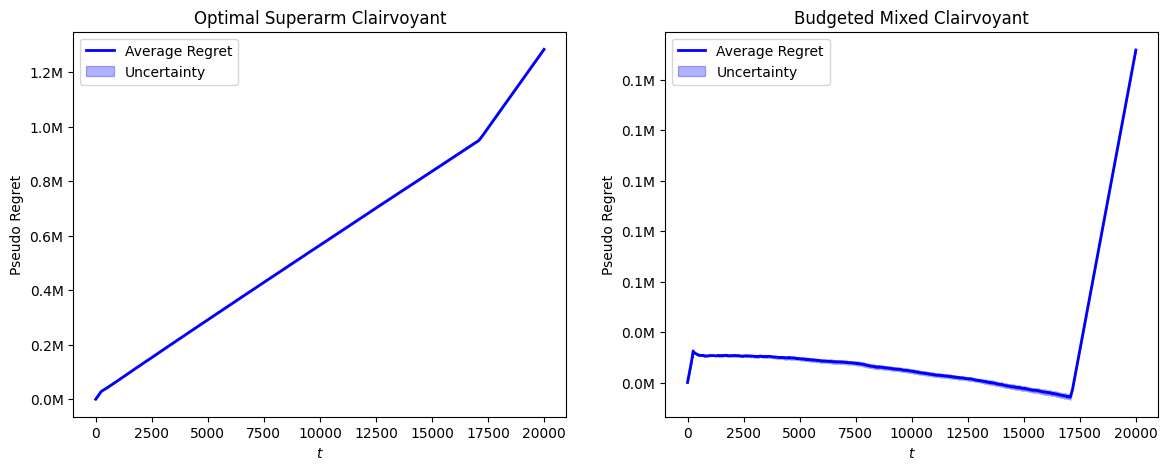

In [16]:
# --- Plotting Average Cumulative Regret (Pseudo Regret) ---
print("Final Total Regret against standard approach:", average_regret[-1])
print("Final Total Regret against Budget-Aware Mixed-Strategy:", average_regret_mixed[-1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

ax1.plot(np.arange(0, T), average_regret, 'b-', linewidth=2, label='Average Regret')
ax1.fill_between(np.arange(0, T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, color='blue', label='Uncertainty')
ax1.set_title('Optimal Superarm Clairvoyant')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Pseudo Regret')
ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

ax2.plot(np.arange(0, T), average_regret_mixed, 'b-', linewidth=2, label='Average Regret')
ax2.fill_between(np.arange(0, T), average_regret_mixed - regret_sd / np.sqrt(n_trials), average_regret_mixed + regret_sd_mixed / np.sqrt(n_trials), alpha=0.3, color='blue', label='Uncertainty')
ax2.set_title('Budgeted Mixed Clairvoyant')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Pseudo Regret')
ax2.legend()
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax2.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

Plot the consumption per-round.

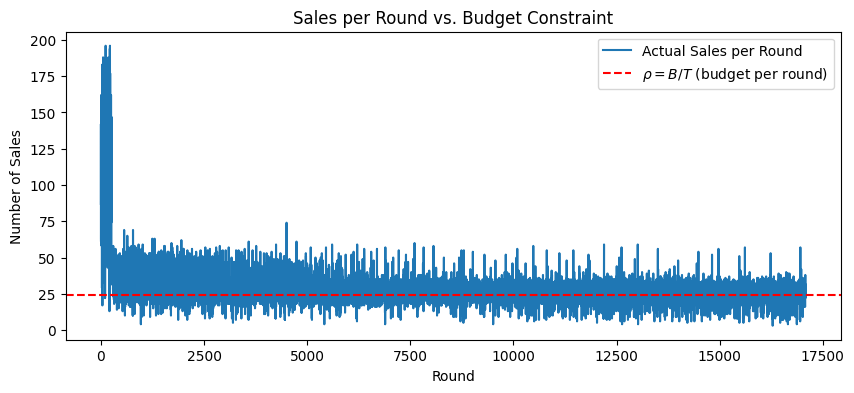

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(sales_per_round, label='Actual Sales per Round')
plt.axhline(y=B/T, color='red', linestyle='--', label=r'$\rho = B/T$ (budget per round)')
plt.xlabel('Round')
plt.ylabel('Number of Sales')
plt.title('Sales per Round vs. Budget Constraint')
_ = plt.legend()

### Dynamic version

Here we try to implement our algorithm using:

$$ 
\rho = \frac{Remaining\ budget}{Remaining\ rounds}
$$

$$ UCB1(i) = \bar{\mu}_i + \sqrt{\frac{2 \ln t}{n_i}} $$

In [18]:
class CombinatorialUCB:
    def __init__(self, N, K, B, T, price_grids, R_ucb, R_lcb):
        self.N = N                      # Number of products
        self.K = K                      # Number of prices per product
        self.B = B                      # Total budget (inventory)
        self.T = T                      # Horizon
        self.R_ucb = R_ucb              # For reward UCB
        self.R_lcb = R_lcb              # For sales LCB
        self.price_grids = price_grids
        self.rho = rho                  # Budget per round
        self.t = 0
        self.inventory = B

        # All possible super-arms = combinations of K indices across N products
        self.super_arms = list(product(range(K), repeat=N))
        self.untried_superarms = set(self.super_arms)  # Track unexplored superarms
        self.A = len(self.super_arms)

        # Per-arm statistics (N products × K prices)
        self.N_pulls = np.zeros((N, K))                 # Number of times (i,k) pulled
        self.avg_rewards = np.zeros((N, K))             # Average reward per (i,k)
        self.avg_sales = np.zeros((self.N, self.K))     # Average sales per (i,k)
        self.last_superarm = None                       # Store last super-arm for update

    def pull_arm(self):
        if self.inventory < 1:
            self.last_superarm = None
            return None
        
        if self.untried_superarms:
            arm = self.untried_superarms.pop()
            self.last_superarm = arm
            return arm

        # Compute UCB and LCB for all (i, k)
        ucb = np.zeros((self.N, self.K))
        lcb_sales = np.zeros((self.N, self.K))
        for i in range(self.N):
            for k in range(self.K):
                # Compute UCB and LCB bounds
                bound_ucb = self.R_ucb[i] * np.sqrt(2 * np.log(self.T) / self.N_pulls[i, k])
                bound_lcb = self.R_lcb[i] * np.sqrt(2 * np.log(self.T) / self.N_pulls[i, k])
                ucb[i, k] = self.avg_rewards[i, k] + bound_ucb
                lcb_sales[i, k] = max(0, self.avg_sales[i, k] - bound_lcb)

        # For each super-arm, sum UCB rewards and LCB sales
        ucb_superarm_rewards = []
        lcb_superarm_sales = []
        for a in self.super_arms:
            reward = sum(ucb[i, a[i]] for i in range(self.N))
            consumption = sum(lcb_sales[i, a[i]] for i in range(self.N))
            ucb_superarm_rewards.append(reward)
            lcb_superarm_sales.append(consumption)

        # Solve LP: max γ ⋅ ucb_rewards s.t. γ ⋅ lcb_sales ≤ ρ, sum γ = 1, γ ≥ 0
        action_idx = self.solve_lp(np.array(ucb_superarm_rewards), np.array(lcb_superarm_sales))
        self.last_superarm = self.super_arms[action_idx]

        return self.last_superarm

    def solve_lp(self, ucb_rewards, lcb_sales):
        c = -ucb_rewards
        A_ub = [lcb_sales]
        b_ub = [self.rho]
        A_eq = [np.ones(self.A)]
        b_eq = [1]
        bounds = [(0, 1)] * self.A

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        if res.success:
            gamma = res.x
            return np.random.choice(self.A, p=gamma)
        else:
            feasible_indices = [i for i, cost in enumerate(lcb_sales) if cost <= self.rho]
            if feasible_indices:
                # Among feasible, pick one with max UCB reward
                best_idx = max(feasible_indices, key=lambda i: ucb_rewards[i])
                return best_idx
            else:
                # No feasible arm even under fallback — return one with *least* consumption
                min_cost_idx = int(np.argmin(lcb_sales))
                return min_cost_idx

    def update(self, sales, individual_rewards):
        for i in range(self.N):
            k = self.last_superarm[i]
            self.N_pulls[i, k] += 1
            self.avg_rewards[i, k] += (individual_rewards[i] - self.avg_rewards[i, k]) / self.N_pulls[i, k]
            self.avg_sales[i, k] += (sales[i] - self.avg_sales[i, k]) / self.N_pulls[i, k]

        self.inventory -= np.sum(sales)
        self.t += 1
        self.rho = self.inventory / (self.T - self.t) if (self.T - self.t) > 0 else 0

Compute regret.

In [19]:
regret_per_trial = []
regret_per_trial_mixed = []
expected_clairvoyant_rewards_per_round = np.sum(best_profits)
expected_clairvoyant_rewards_per_round_mixed = clairvoyant_mixed_reward_per_round

# Run n-trials
for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironmentMultiProduct(costs=costs, mean_valuations=values, std_valuations=std_valuations, buyers_per_round=buyers_per_round)

    agent = CombinatorialUCB(N, K, B, T, price_grids, R_ucb=R_ucb, R_lcb=R_lcb)
    regret_over_time_this_trial = []
    regret_over_time_this_trial_mixed = []
    current_run_actions = []
    sales_per_round = []

    # Time horizon loop
    rewards_this_trial = []
    for t in range(T):
        a_t = agent.pull_arm()

        if seed == n_trials - 1 and a_t is not None:
            current_run_actions.append(tuple(a_t))

        if a_t is None:
            # If agent stops early, fill remaining rounds with 0 reward
            rewards_this_trial.extend([0] * (T - t))
            break

        prices = [price_grids[i][a_t[i]] for i in range(N)]
        sales, total_reward, rewards_per_product = env.round(prices)
        agent.update(sales, rewards_per_product)

        if seed == n_trials - 1:
            sales_per_round.append(np.sum(sales))  # Track total sales this round

        rewards_this_trial.append(total_reward)

    # Compute regret arrays for this trial
    regret_per_trial.append(np.cumsum(expected_clairvoyant_rewards_per_round - np.array(rewards_this_trial)))
    regret_per_trial_mixed.append(np.cumsum(expected_clairvoyant_rewards_per_round_mixed - np.array(rewards_this_trial)))

    if seed == n_trials - 1:
        last_run_actions = current_run_actions

# Compute average (and standard deviation) of regret across all trials
average_regret = np.array(regret_per_trial).mean(axis=0)
average_regret_mixed = np.array(regret_per_trial_mixed).mean(axis=0) 
regret_sd = np.array(regret_per_trial).std(axis=0)
regret_sd_mixed = np.array(regret_per_trial_mixed).std(axis=0)

Plot.

Final Total Regret against standard approach: 1247211.2578001514
Final Total Regret against Budget-Aware Mixed-Strategy: 127502.81606664845


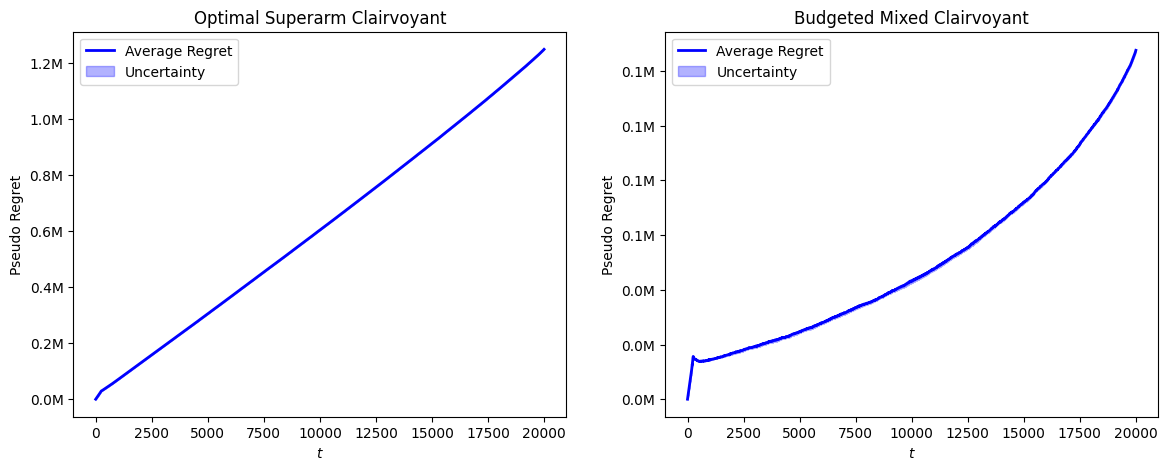

In [20]:
# --- Plotting Average Cumulative Regret (Pseudo Regret) ---
print("Final Total Regret against standard approach:", average_regret[-1])
print("Final Total Regret against Budget-Aware Mixed-Strategy:", average_regret_mixed[-1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

ax1.plot(np.arange(0, T), average_regret, 'b-', linewidth=2, label='Average Regret')
ax1.fill_between(np.arange(0, T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, color='blue', label='Uncertainty')
ax1.set_title('Optimal Superarm Clairvoyant')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Pseudo Regret')
ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

ax2.plot(np.arange(0, T), average_regret_mixed, 'b-', linewidth=2, label='Average Regret')
ax2.fill_between(np.arange(0, T), average_regret_mixed - regret_sd / np.sqrt(n_trials), average_regret_mixed + regret_sd_mixed / np.sqrt(n_trials), alpha=0.3, color='blue', label='Uncertainty')
ax2.set_title('Budgeted Mixed Clairvoyant')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Pseudo Regret')
ax2.legend()
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax2.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

Which arms did it play?

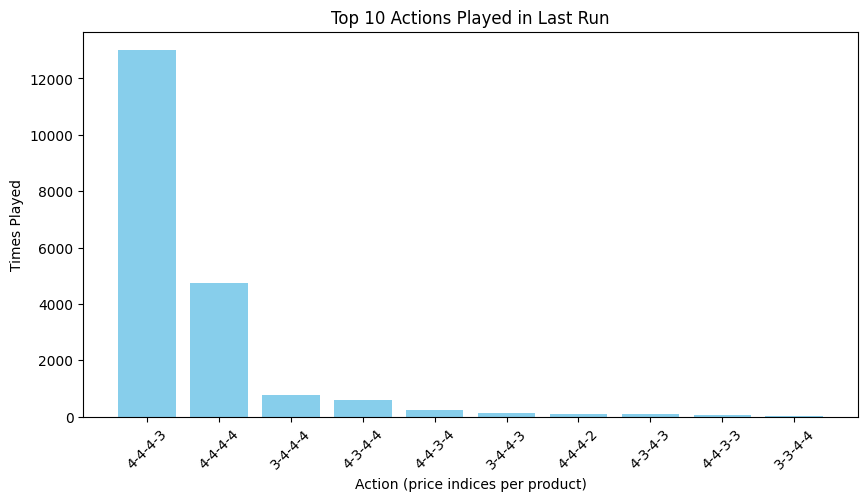

In [21]:
# Count how many times each action was played
action_counts = Counter(last_run_actions)
# Sort actions by frequency
most_common_actions = action_counts.most_common(10)  # Show top 10 actions
# Prepare labels and values
action_labels = action_labels = ['-'.join(str(i + 1) for i in action) for action, _ in most_common_actions]
action_freqs = [count for _, count in most_common_actions]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(action_labels, action_freqs, color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Action (price indices per product)")
plt.ylabel("Times Played")
_ = plt.title("Top 10 Actions Played in Last Run")